# Spam or Ham?

## Lab Assignment Two: Exploring Text Data 

### Justin Ledford, Luke Wood, Traian Pop 
___

## Business Understanding

### Data Background
SMS messages play a huge role in a person's life, and the confidentiality and integrity of said messages are of the highest priority to mobile carriers around the world. Due to this fact, many unlawful individuals and groups try and take advantange of the average consumer by flooding their inbox with spam, and while the majority of people successfully avoid it, there are people out there affected negatively by falling for false messages.  

The data we selected is a compilation of 5574 SMS messages acquired from a variety of different sources, broken down in the following way: 452 of the messages came from the Grumbletext Web Site, 3375 of the messages were taken from the NUS SMS Corpus (database with legitimate message from the University of Singapore), 450 messages collected from Caroline Tag's PhD Thesis, and the last 1324 messages were from the SMS Spam Corpus v.0.1 Big. 

Overall there were 4827 "ham" messages and 747 "spam" messages, and about 92,000 words.

### Purpose
This data was collected initially for studies on deciphering the differences between a spam or ham (legitimate) messages. Uses for this research can involve advanced spam filtering technology or improved data sets for machine learning programs. However, a slight problem with this data set, as with most localized language-based data sets, is that due to the relatively small area of sampling, there are a lot of regional data points (such as slang, acronyms, etc) that can be considering "useless" data if a much more generalized data set is wanted. For our specific project however, we are keeping all this data in order for us to analyze it and get a better understanding of our data.
___

## Preparation (40 points total)

### [20 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).   

In [35]:
import pandas as pd
import numpy as np
import requests
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

descriptors_url = 'https://raw.githubusercontent.com/LukeWoodSMU/TextAnalysis/master/data/SMSSpamCollection'
descriptors = requests.get(descriptors_url).text
texts = []


for line in descriptors.splitlines():
    texts.append(line.rstrip().split("\t"))

After the first look at the data we noticed a lot of phone numbers. Since almost every number was unique we concluded that the numbers were irrelevant to consider as words. We considered grouping all number tokens into one token and analyze the presence of words, but we decided to first start by just removing the numbers.

In [36]:
# Remove numbers
texts = list(zip([a for a,b in texts], [re.sub('((\(\d{3}\) ?)|(\d{3}-))?\d{3}-\d', 'PHONE_NUMBER', b) for a,b in texts]))

Citation: regex from google search top results/stack overflow

In [37]:
import numpy as np
from keras.preprocessing import sequence

In [38]:
X = [x[1] for x in texts]
y = [x[0] for x in texts]
X = np.array(X)
print(type(X))

<class 'numpy.ndarray'>


In [39]:
import keras
y = [0 if y_ == "spam" else 1 for y_ in y]
y_ohe = keras.utils.to_categorical(y)
y_ohe

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

We assign spam as a value of 0 and ham as a value of one so that we can use precision score to measure false positive scores.

In [40]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(X)
sequences = pad_sequences(sequences)

MAX_TEXT_LEN = len(sequences[0]) # maximum and minimum number of words

We tokenize and measure the max length of the text using keras' tokenizer.

### [10 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

We now have an embedding matrix for our word index.

Finally, we split our data into training data and testing data.  We stratify the data on y_ohe to ensure that we get a fair representation of the spam and ham messages.  We believe this to be appropriate because each model needs to see a fair number of both spam messages and ham messages to ensure it does not overtrain on either.
# TODO: write more on this

In [41]:
from sklearn.model_selection import train_test_split
# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(sequences, y_ohe, test_size=0.2,
                                                            stratify=y_ohe, 
                                                            random_state=42)
NUM_CLASSES = len(y_train_ohe[0])
NUM_CLASSES

2

# Evaluation Metrics
We decided that due to our business understanding being that we can potentially create a spam filter, our largest cost should be false positives.  It would be incredibly frustrating to have a real text filtered out so we should evaluate our models in accordance with this.  To evaluate this, we must implement precision score which has been removed from keras.  Luckily, the old code is available in a one of keras' old versions.

In [42]:
# Old version of keras had precision score, copied the code to re-implement it.
import keras.backend as K
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

Citation: old keras version

# Building a Single Model
To avoid the need for training our own embedding layer which is incredibly computationally expensive, we load up a pretrained glove embedding.

In [43]:
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('GLOVE/glove.6B/glove.6B.100d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Found 400000 word vectors.
(9008, 100)


In [44]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_TEXT_LEN,
                            trainable=False)
metrics=[precision,"accuracy"]

In [45]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=metrics)
print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 189, 100)          900800    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 981,402
Trainable params: 80,602
Non-trainable params: 900,800
_________________________________________________________________
None


In [12]:
rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=3, batch_size=64)

Train on 4459 samples, validate on 1115 samples
Epoch 1/3
4459/4459 [==============================] - 41s - loss: 0.2196 - precision: 0.9709 - acc: 0.9222 - val_loss: 0.1293 - val_precision: 0.9937 - val_acc: 0.9543

# Comparing Different Model Types

To begin, we will evaluate a network using an LSTM cell, a GRU cell, and a SimpleRNN cell.  We will use a standard hyperparameter set to evaluate the results and decide which two architectures we want to explore in depth based on the results.

In [46]:
from keras.layers import LSTM, GRU, SimpleRNN

rnns = []

for func in [SimpleRNN, LSTM, GRU]:
    rnn = Sequential()
    rnn.add(embedding_layer)
    rnn.add(func(100,dropout=0.2, recurrent_dropout=0.2))
    rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))

    rnn.compile(loss='categorical_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=metrics)
    rnns.append(rnn)

In [14]:
for rnn, name in zip(rnns,['simple','lstm','gru']):
    print('\nTesting Cell Type: ',name,'========')
    rnn.fit(X_train, y_train_ohe, epochs=3, batch_size=64, validation_data=(X_test, y_test_ohe))

Testing Cell Type:  simple ========
Train on 4459 samples, validate on 1115 samples
Epoch 1/3
4459/4459 [==============================] - 8s - loss: 0.2695 - precision: 0.8955 - acc: 0.8955 - val_loss: 0.1736 - val_precision: 0.9533 - val_acc: 0.9381

As we can see, the GRU model performs the best by a large margin.  If we continue to train the GRU model it seems that we will get some really great results.  We will try also try to find the best hyperparameters for the GRU model.

After we find the best GRU results we will use an LSTM and then measure the results of the LSTM.

# Gridsearch on GRU Model

In [15]:
dropouts=[.1,.2,.3]
recurrent_dropouts=[.1,.2,.3]

for dropout in dropouts:
    for recurrent_dropout in recurrent_dropouts:
        rnn = Sequential()
        rnn.add(embedding_layer)
        rnn.add(func(100,dropout=dropout, recurrent_dropout=recurrent_dropout))
        rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))

        rnn.compile(loss='categorical_crossentropy', 
                      optimizer='rmsprop', 
                      metrics=metrics)
        print("Hyper Paramater Set:\n\tdropout=%.1f\n\trecurrent_dropout=%.1f" % (dropout,recurrent_dropout))
        rnn.fit(X_train,y_train_ohe,epochs=3, batch_size=64, validation_data=(X_train,y_train_ohe))

Hyper Paramater Set:
	dropout=0.1
	recurrent_dropout=0.1
Train on 4459 samples, validate on 4459 samples
Epoch 1/3
4459/4459 [==============================] - 35s - loss: 0.2053 - precision: 0.9481 - acc: 0.9161 - val_loss: 0.1584 - val_precision: 0.9821 - val_acc: 0.9424

###### We get some pretty ridiculously high accuracy with both of our hyperparameters set to .1

As we can see, with dropout and recurrent dropout at .1 we get some really great results; with accuracy getting as high as 98.6%.  This is ridiculously high.  The model gets .997 precision and .98 accuracy on the validation set with these hyperparameters.

We actually get a similar precision score in a few sets of hyperparameters, but we get a higher accuracy with the .1 and .1 set so this is our most effective model.

In [47]:
best_model = Sequential()
best_model.add(embedding_layer)
best_model.add(GRU(100,dropout=.1, recurrent_dropout=.1))
best_model.add(Dense(NUM_CLASSES, activation='sigmoid'))
best_model.compile(loss='categorical_crossentropy', 
                      optimizer='rmsprop', 
                      metrics=metrics)

# Running Our Best Model With More Epochs

In [16]:
best_model.fit(X_train,y_train_ohe,epochs=10, batch_size=64, validation_data=(X_train,y_train_ohe))

Train on 4459 samples, validate on 4459 samples
Epoch 1/10
4459/4459 [==============================] - 36s - loss: 0.2041 - precision: 0.9385 - acc: 0.9208 - val_loss: 0.0910 - val_precision: 0.9901 - val_acc: 0.9688

###### We end up getting above 99.5% accuracy and a precision score of .9986 on the validation set!  We could absolutely use this to publish a spam filter.  This is a very good score on this dataset.

# Grid Search Using LSTM

Now that we know we can get results as high as 99.5% accuracy and 99.8% precision with the GRU network we will try to see how high we can get our LSTM's score.

In [16]:
dropouts=[.1,.2,.3]
recurrent_dropouts=[.1,.2,.3]

for dropout in dropouts:
    for recurrent_dropout in recurrent_dropouts:
        rnn = Sequential()
        rnn.add(embedding_layer)
        rnn.add(LSTM(100,dropout=dropout, recurrent_dropout=recurrent_dropout))
        rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))

        rnn.compile(loss='categorical_crossentropy', 
                      optimizer='rmsprop', 
                      metrics=metrics)
        print("Hyper Paramater Set:\n\tdropout=%.1f\n\trecurrent_dropout=%.1f" % (dropout,recurrent_dropout))
        rnn.fit(X_train,y_train_ohe,epochs=3, batch_size=64, validation_data=(X_train,y_train_ohe))

Hyper Paramater Set:
	dropout=0.1
	recurrent_dropout=0.1
Train on 4459 samples, validate on 4459 samples
Epoch 1/3
4459/4459 [==============================] - 48s - loss: 0.1968 - precision: 0.9571 - acc: 0.9278 - val_loss: 0.1018 - val_precision: 0.9885 - val_acc: 0.9639

###### As we can see, our best LSTM hyper parameter set is with a dropout of .1 and a recurrent dropout of .2.  We will create this network and train it with more epochs.

In [48]:
best_lstm = Sequential()
best_lstm.add(embedding_layer)
best_lstm.add(LSTM(100,dropout=.1, recurrent_dropout=.2))
best_lstm.add(Dense(NUM_CLASSES, activation='sigmoid'))
best_lstm.compile(loss='categorical_crossentropy', 
                      optimizer='rmsprop', 
                      metrics=metrics)

# Comparison of our 2 best models

In [118]:
%%time

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, precision_score

sss = StratifiedShuffleSplit(n_splits=3)

gru_scores = []
gru_cms = []
lstm_scores = []
lstm_cms = []

split_num = 1
for train_index, test_index in sss.split(sequences, y_ohe):
    print('Split #{}'.format(split_num))
    split_num += 1
    X_train, X_test = sequences[train_index], sequences[test_index]
    y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]
    
    # one hot decode for scoring
    y_test = [list(x).index(1.0) for x in list(y_test_ohe)] 
    
    best_model.fit(X_train,y_train_ohe,epochs=3,
                   batch_size=64,validation_data=(X_train,y_train_ohe),verbose=0)
    y_hat = best_model.predict(X_test)
    
    # one hot decode for scoring
    y_hat = np.array([[0,1] if np.argmax(x) == 1 else [1,0] for x in y_hat]).astype(float)
    y_hat = [list(x).index(1.0) for x in list(y_hat)]
    
    gru_scores.append(precision_score(y_test, y_hat))
    gru_cms.append(confusion_matrix(y_test, y_hat))
    
    print(gru_scores[-1])
    print(gru_cms[-1])
    
    best_lstm.fit(X_train,y_train_ohe,epochs=3,
                   batch_size=64,validation_data=(X_train,y_train_ohe),verbose=0)
    y_hat = best_lstm.predict(X_test)
    
    # one hot decode for scoring
    y_hat = np.array([[0,1] if np.argmax(x) == 1 else [1,0] for x in y_hat]).astype(float)
    y_hat = [list(x).index(1.0) for x in list(y_hat)]
    
    lstm_scores.append(precision_score(y_test, y_hat))
    lstm_cms.append(confusion_matrix(y_test, y_hat))
    
    print(lstm_scores[-1])
    print(lstm_cms[-1])

Split #1
0.995780590717
[[ 84   2]
 [  0 472]]
0.985386221294
[[ 79   7]
 [  0 472]]
Split #2
1.0
[[ 84   0]
 [  0 474]]
0.991631799163
[[ 80   4]
 [  0 474]]
Split #3
1.0
[[ 70   0]
 [  0 488]]
0.993890020367
[[ 67   3]
 [  0 488]]
CPU times: user 45min 55s, sys: 5min 6s, total: 51min 1s
Wall time: 16min 21s


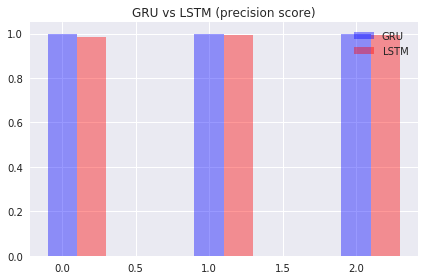

In [120]:
# Plot bar graphs
bar_width = 0.20
index = np.arange(3)
opacity=0.4

plt.bar(index, gru_scores, bar_width, align='center',
        color='b', label='GRU', alpha=opacity)
plt.bar(index + bar_width, lstm_scores, bar_width,
        align='center', color='r', label='LSTM', alpha=opacity)
plt.title('GRU vs LSTM (precision score)')

plt.legend()
plt.tight_layout()
plt.show()

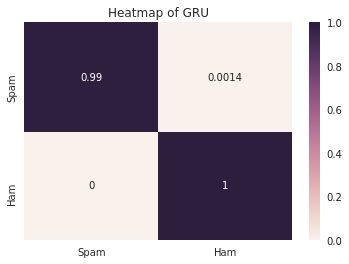

In [141]:
# Plot heatmap
labels = ['Spam', 'Ham']
gru_cm_avg = np.zeros((2,2))
for cm in gru_cms:
    # turn cm into percentages
    cm_ = cm / np.sum(cm, axis=1).T / 3
    gru_cm_avg = np.sum([gru_cm_avg, cm_], axis=0)
    
sns.heatmap(gru_cm_avg, annot=True, xticklabels=labels, yticklabels=labels)
plt.title('Heatmap of GRU')

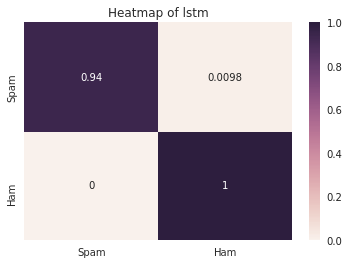

In [142]:
# Plot heatmap
lstm_cm_avg = np.zeros((2,2))
for cm in lstm_cms:
    # turn cm into percentages
    cm_ = cm / np.sum(cm, axis=1).T / 3
    lstm_cm_avg = np.sum([lstm_cm_avg, cm_], axis=0)
    
sns.heatmap(lstm_cm_avg, annot=True, xticklabels=labels, yticklabels=labels)
plt.title('Heatmap of lstm')

# todo: cross validation

[25 points] Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Adjust hyper-parameters of the networks as needed to improve generalization performance. 
[25 points] Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. Visualize the best results of the RNNs.   
Exceptional Work (10 points total)
You have free reign to provide additional analyses.
One idea: Use more than a single chain of LSTMs or GRUs (i.e., use multiple parallel chains). 
Another Idea: Try to create a RNN for generating novel text. 

# NLTK tokenize vs keras tokenizer.

We thought it could be interesting to compare the generalized NLTK tokenizer to the keras tokenizer.  We decided to compare them using basic LSTM networks.

In [17]:
from nltk.tokenize import word_tokenize
X_nltk = [word_tokenize(x) for x in X]

In [18]:
encoder = {}
counter = 0
def encode_sentence(seq):
    global encoder, counter
    fseq = []
    for x in seq:
        if x not in encoder:
            encoder[x] = counter
            counter+=1
        fseq.append(encoder[x])
    return fseq

X_nltk = [encode_sentence(x) for x in X]
X_nltk = pad_sequences(X_nltk, maxlen=None)

In [19]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=len(X_nltk[0]),
                            trainable=False)

In [20]:
rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=metrics)
print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 910, 100)          862100    
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 202       
Total params: 942,702.0
Trainable params: 80,602.0
Non-trainable params: 862,100.0
_________________________________________________________________
None


In [ ]:
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X_nltk, y_ohe, test_size=0.2,
                                                            stratify=y_ohe, 
                                                            random_state=42)

In [ ]:
rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=3, batch_size=64)

Train on 4459 samples, validate on 1115 samples
Epoch 1/3


# KerasGlove Published to PyPi
I really liked being able to easily use glove embeddings with keras so I published a package to PyPi for it.  It's available under kerasglove and removes the need for a lot of the code in the notebook.  Here is a sample usage of it:

In [33]:
from kerasglove import GloveEmbedding
EMBED_SIZE=100
metrics = ['accuracy',precision]

embed_layer = GloveEmbedding(
                            EMBED_SIZE,
                            MAX_TEXT_LEN,
                            word_index)
embed_layer

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from kerasglove import GloveEmbedding

rnn = Sequential()
rnn.add(GloveEmbedding(EMBED_SIZE,
                            MAX_TEXT_LEN,
                            word_index))
rnn.add(GRU(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=metrics)
print(rnn.summary())

In [ ]:
rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=3, batch_size=64)

As we can see, this is far easier to construct a network with a pre trained GloVe emebedding than doing it manually.

The full source is here:
https://github.com/LukeWoodSMU/KerasGlove